In [15]:
# Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)

In [16]:
df = pd.read_csv("../data/processed/all_shots_final.csv", index_col=0)
df.drop(['PLAYER1_NAME'], axis=1, inplace=True)
df.dropna(inplace=True)
df.columns

Index(['Shot Distance', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Mid-Range', 'Shot Zone Basic_Right Corner 3',
       'Shot Zone Area_Left Side(L)', 'Shot Zone Range_16-24 ft.',
       'Shot Zone Range_24+ ft.', 'Shot Zone Range_Less Than 8 ft.',
       'PREVIOUS_OFF_REBOUND', 'PREVIOUS_OFF_MISSED', 'TS%', 'USG%', 'PTS',
       'weight', 'E_DEF_RATING', 'PCT_AREA', 'DETAILLED_SHOT_TYPE_OTHER',
       'target'],
      dtype='object')

In [17]:
df.corr()['target'].abs().sort_values(ascending=False)[:15]

target                                   1.000000
Shot Zone Range_24+ ft.                  0.163813
PCT_AREA                                 0.134223
PREVIOUS_OFF_MISSED                      0.132910
Shot Distance                            0.129900
Shot Zone Range_16-24 ft.                0.121424
Shot Zone Basic_In The Paint (Non-RA)    0.105864
Shot Zone Basic_Mid-Range                0.105531
Shot Zone Area_Left Side(L)              0.095921
DETAILLED_SHOT_TYPE_OTHER                0.061137
TS%                                      0.043891
Shot Zone Range_Less Than 8 ft.          0.040923
Shot Zone Basic_Right Corner 3           0.033867
E_DEF_RATING                             0.022016
PTS                                      0.014000
Name: target, dtype: float64

## Séparation des données

In [18]:
# prepare data for modeling   
X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)

## Standardisation et réduction de dimension

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_scaled['target'] = y_train

# réduction de dimensions
sel_var = VarianceThreshold(0.0001)
X_train_scaled = sel_var.fit_transform(X_train_scaled, y_train)
X_test_scaled = sel_var.transform(X_test_scaled)

# réduction de dimensions
sel_k_best = SelectKBest(f_classif, k = 20)
sel_k_best.fit(X_train, y_train)
X_train_kbst = sel_k_best.transform(X_train)
X_test_kbst = sel_k_best.transform(X_test)

# Affichage des variables sélectionnées
# kbst = pd.DataFrame(sel_k_best.get_support(), index=X_train.columns)
# kbst["score"]=sel_k_best.scores_
# kbst.sort_values("score", ascending=False)

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Composantes Principales retenues :  12


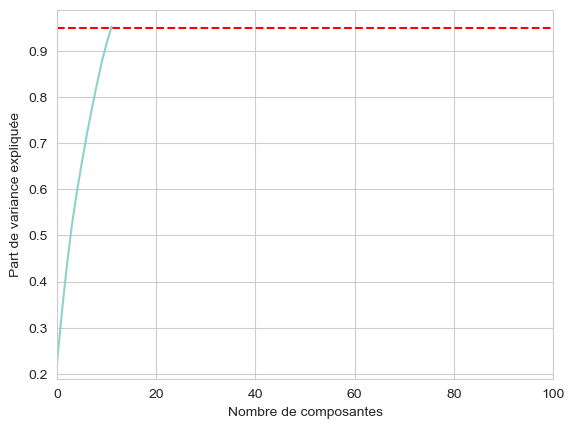

In [20]:
pca = PCA()
pca.fit(X_train_scaled)

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Composantes Principales retenues : ", pca.n_components_)

plt.figure()
plt.xlim(0,100)
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.95, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

## Arbre de décision

In [24]:
dt_clf = DecisionTreeClassifier(criterion='log_loss', max_depth=5)

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print('Train accuracy with DT:', dt_clf.score(X_train, y_train))
print('Test accuracy with DT:', dt_clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy with DT: 0.6793551132720044
Test accuracy with DT: 0.6791539869646834


Classes prédites,0,1
Classes réelles,,
0,22266,15080
1,12438,35983


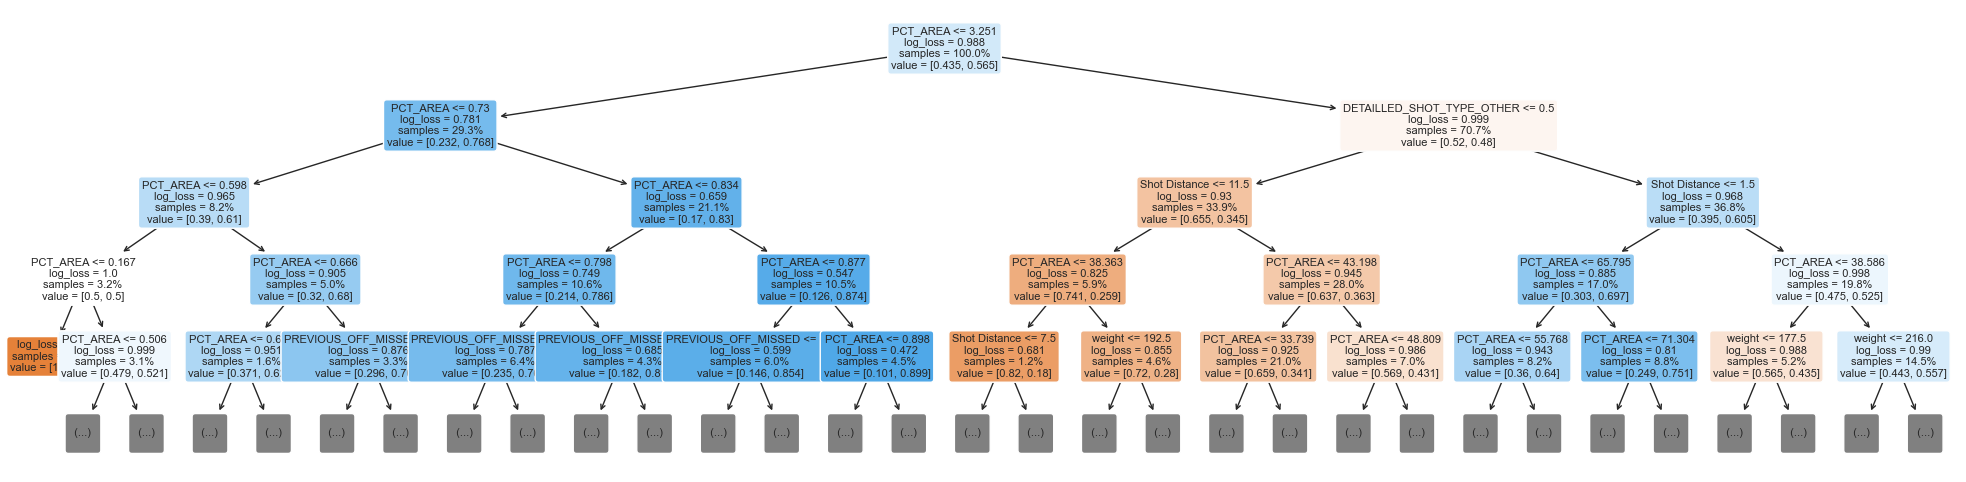

In [9]:
plt.figure(figsize=(25,6))
plot_tree(dt_clf,feature_names=X_train.columns, filled=True, proportion=True, rounded=True, fontsize=8, max_depth=4)
plt.show()

In [10]:
import optuna

def dtree_objective(trial):
    
    md = trial.suggest_int('max_depth', 2, 64)
    mi = trial.suggest_int('min_samples_split', 2, 32)
    cr = trial.suggest_categorical("criterion", ["entropy", "gini", "log_loss"])
    minleaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    clf =  DecisionTreeClassifier(max_depth=md, min_samples_leaf=minleaf, criterion=cr, min_samples_split=mi)

    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    return scores.mean()
    
dtree_study = optuna.create_study(direction='maximize')
dtree_study.optimize(dtree_objective, n_trials=20)

print("Number of finished trials: ", len(dtree_study.trials))
print("Best trial:")
trial = dtree_study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-13 11:34:13,997] A new study created in memory with name: no-name-30607bfc-d377-4682-a069-8fc63e8e7414
[I 2024-09-13 11:34:19,310] Trial 0 finished with value: 0.6486993818777887 and parameters: {'max_depth': 55, 'min_samples_split': 24, 'criterion': 'gini', 'min_samples_leaf': 12}. Best is trial 0 with value: 0.6486993818777887.
[I 2024-09-13 11:34:24,393] Trial 1 finished with value: 0.6589160103874335 and parameters: {'max_depth': 58, 'min_samples_split': 27, 'criterion': 'gini', 'min_samples_leaf': 25}. Best is trial 1 with value: 0.6589160103874335.
[I 2024-09-13 11:34:30,865] Trial 2 finished with value: 0.6319301120781156 and parameters: {'max_depth': 62, 'min_samples_split': 9, 'criterion': 'log_loss', 'min_sam

Number of finished trials:  20
Best trial:
  Value: 0.6795941334095416
  Params: 
    max_depth: 9
    min_samples_split: 12
    criterion: log_loss
    min_samples_leaf: 28


# Régression Logistique

In [26]:
scaler = StandardScaler()

lr = LogisticRegression(solver='liblinear', max_iter=1000)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print('Train accuracy:', lr.score(X_train_scaled, y_train))
print('Test accuracy:', lr.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])


Train accuracy: 0.6603559644152179
Test accuracy: 0.6616530833537374


Classes prédites,0,1
Classes réelles,,
0,20710,16636
1,12383,36038


In [99]:
n = X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()

pipeline_pca = Pipeline(steps = [('normalization', scaler),
                                 ('pca', pca)])

X_new = pipeline_pca.fit_transform(X_train)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = pipeline.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='income')], axis=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(15)

ax.set_facecolor('xkcd:salmon')

sns.scatterplot(x='PC1', y='PC2', hue='income', data=finalDF, alpha=0.5, ax=ax)
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 0.8)
plt.ylim(-0.8, 0.8)

## Random Forest

In [29]:
clf = RandomForestClassifier(n_jobs = -1, criterion='log_loss', max_depth=5)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print('Train accuracy:', clf.score(X_train_scaled, y_train))
print('Test accuracy:', clf.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6738139377616099
Test accuracy: 0.6734291743910829


Classes prédites,0,1
Classes réelles,,
0,22810,14536
1,13473,34948


## XGBoost

In [124]:
import xgboost as xgb
import optuna


train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)


def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, train)
    preds = bst.predict(test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-13 11:38:48,134] A new study created in memory with name: no-name-d55795ea-04c8-4787-a431-b1051b267d03
[I 2024-08-13 11:39:17,094] Trial 0 finished with value: 0.6174308795084765 and parameters: {'booster': 'gbtree', 'lambda': 0.4711964398765692, 'alpha': 0.0017178653097182672, 'subsample': 0.5040356031783092, 'colsample_bytree': 0.9400073674547469, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.030497250942591588, 'gamma': 0.002484742893580052, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6174308795084765.
[I 2024-08-13 11:39:30,723] Trial 1 finished with value: 0.5638297872340425 and parameters: {'booster': 'gbtree', 'lambda': 2.9242471073215743e-05, 'alpha': 2.9274634068751614e-07, 'subsample': 0.6033805237546999, 'colsample_bytree': 0.4972086179481197, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.0026469873895545084, 'gamma': 2.160451814547953e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6174308795084765.
[I 2024-08-13 11:39:33,035] 

Number of finished trials:  50
Best trial:
  Value: 0.6864375924451018
  Params: 
    booster: dart
    lambda: 0.2944545686385192
    alpha: 0.0007407566537411825
    subsample: 0.5766218331240859
    colsample_bytree: 0.9190832414217771
    max_depth: 9
    min_child_weight: 2
    eta: 0.18933879307911025
    gamma: 1.2445363285625764e-06
    grow_policy: depthwise
    sample_type: weighted
    normalize_type: tree
    rate_drop: 3.32312193233679e-05
    skip_drop: 4.123907571803158e-05


## KNN Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print('Train accuracy:', clf.score(X_train_scaled, y_train))
print('Test accuracy:', clf.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.7069414809891916
Test accuracy: 0.651264472349505


Classes prédites,0,1
Classes réelles,,
0,23941,13405
1,16505,31916


In [32]:
from sklearn.svm import SVC

clf = SVC(C=0.1)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print('Train accuracy:', clf.score(X_train_scaled, y_train))
print('Test accuracy:', clf.score(X_test_scaled, y_test))
pd.crosstab(y_test, y_pred, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6756677976377861
Test accuracy: 0.6759359660475475


Classes prédites,0,1
Classes réelles,,
0,20619,16727
1,11067,37354


In [35]:
import joblib
joblib.dump(clf, "trained_svm.save")

['trained_svm.save']

## XGBoost

In [37]:
import xgboost as xgb

train = xgb.DMatrix(data=X_train_scaled, label=y_train)
test = xgb.DMatrix(data=X_test_scaled, label=y_test)

params = {"objective": "binary:logistic"}
clf = xgb.train(params, train)
train_preds = clf.predict(train)
tests_preds = clf.predict(test)
y_pred_train = np.rint(train_preds)
y_pred_test = np.rint(tests_preds)
print('Train accuracy:', accuracy_score(y_train, y_pred_train ))
print('Test accuracy:', accuracy_score(y_test, y_pred_test ))
pd.crosstab(y_test, y_pred_test, rownames=["Classes réelles"], colnames=["Classes prédites"])

Train accuracy: 0.6805764454860261
Test accuracy: 0.6805064885095666


Classes prédites,0.0,1.0
Classes réelles,,
0,22349,14997
1,12405,36016
